# IRIS Online Review Prediction Model
The task of this hackathon challenge is to create a predictive model to classify online electronics reviews into five categories, ranking from 1 (lowest) to 5 (highest). Both train sets and test sets are provided. We recommend the following guidelines in preparing the data set, training/testing the model, and applying it to the final test set. 

1. Resampling the dataset into more balanced dataset due to the nature of online reviews.
2. Feature engineering - cleansing and expanding the data set into a set of features that text mining algorithms expect.
3. Testing the model by cross validation.
4. Apply the model to a test set and report the results for scoring.

This document aims at explaing step by step the concepts and procedures in the making of the predictive model.

## Reading in the data

In [193]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

To read the entire training set into memory and train the model based on all of it has two major downsides:
1. The sheer volume (1.6 million rows) of the data would incur high computational cost. Given the time constraint in the hackathon, such computational load is inhibitive.
2. The data set is unbalanced by nature. Most reviews collected are positive (4-5), while neutral and below (1-3) are much rarer. Training the model on such data set will likely lead to biased prediction. The histogram shows the unbalanced nature of the dataset.

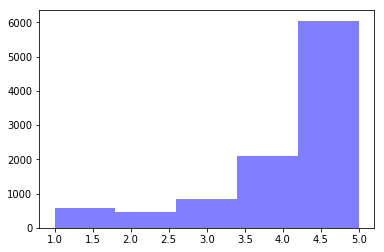

In [194]:
%matplotlib inline
train = pd.read_csv('train.csv')
train = train.loc[1:10000,:]
num_bins = 5
n, bins, patches = plt.hist(train['Rating'], num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [ ]:
# Resampling code goes here

We start by counting the number of words and number of characters in each reviews, as well as the average length of words. These three new features are appended to the training data set as new features. The techniques are self-explanatory in the code below.

In [168]:
train['word_count'] = train['ReviewText'].apply(lambda x: len(str(x).split(" ")))
train[['ReviewText','word_count']].head()

,ReviewText,word_count
1,"I'm a professional OTR truck driver, and I bou...",446
2,"Well, what can I say. I've had this unit in m...",888
3,"Not going to write a long review, even thought...",449
4,I've had mine for a year and here's what we go...,202
5,I am using this with a Nook HD+. It works as d...,22


### Number of characters

In [169]:
train['char_count'] = train['ReviewText'].str.len() ## this also includes spaces
train[['ReviewText','char_count']].head()

,ReviewText,char_count
1,"I'm a professional OTR truck driver, and I bou...",2175.0
2,"Well, what can I say. I've had this unit in m...",4607.0
3,"Not going to write a long review, even thought...",2246.0
4,I've had mine for a year and here's what we go...,1076.0
5,I am using this with a Nook HD+. It works as d...,109.0


### Average Word Length

In [170]:
def avg_word(sentence):
  #print(sentence)
  sentence = str(sentence)
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

train['avg_word'] = train['ReviewText'].apply(lambda x: avg_word(x))
train[['ReviewText','avg_word']].head()

,ReviewText,avg_word
1,"I'm a professional OTR truck driver, and I bou...",4.051522
2,"Well, what can I say. I've had this unit in m...",4.397163
3,"Not going to write a long review, even thought...",4.004454
4,I've had mine for a year and here's what we go...,4.331683
5,I am using this with a Nook HD+. It works as d...,4.000000


Number of Stop Words

One of the major forms of pre-processing is to filter out useless data. In natural language processing, useless words (data), are referred to as stop words. A stop word is a commonly used word (such as “the”, “a”, “an”, “in”). The algorithm below identifies such words in English and count the number of occurences in each review.

In [171]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#print(train['ReviewText'])
#train['ReviewText',:] = str(train['ReviewText',:])

train['stopwords'] = train['ReviewText'].apply(lambda x: len([x for x in str(x).split() if x in stop_words]))
train[['ReviewText','stopwords']].head()

,ReviewText,stopwords
1,"I'm a professional OTR truck driver, and I bou...",177
2,"Well, what can I say. I've had this unit in m...",362
3,"Not going to write a long review, even thought...",196
4,I've had mine for a year and here's what we go...,86
5,I am using this with a Nook HD+. It works as d...,8


Number of Special Characters

In [172]:
train['hastags'] = train['ReviewText'].apply(lambda x: len([x for x in str(x).split() if x.startswith('#')]))
train[['ReviewText','hastags']].head()

,ReviewText,hastags
1,"I'm a professional OTR truck driver, and I bou...",0
2,"Well, what can I say. I've had this unit in m...",0
3,"Not going to write a long review, even thought...",0
4,I've had mine for a year and here's what we go...,0
5,I am using this with a Nook HD+. It works as d...,0


Number of Numerics

In [173]:
train['numerics'] = train['ReviewText'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
train[['ReviewText','numerics']].head()

,ReviewText,numerics
1,"I'm a professional OTR truck driver, and I bou...",7
2,"Well, what can I say. I've had this unit in m...",7
3,"Not going to write a long review, even thought...",6
4,I've had mine for a year and here's what we go...,1
5,I am using this with a Nook HD+. It works as d...,0


Making every review lower case

In [174]:
train['ReviewText'] = train['ReviewText'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
train['ReviewText'].head()
# Translate here later
#translateDiction = pd.read_csv('Contractions.csv')
#print(translateDiction)

1    i'm a professional otr truck driver, and i bou...
2    well, what can i say. i've had this unit in my...
3    not going to write a long review, even thought...
4    i've had mine for a year and here's what we go...
5    i am using this with a nook hd+. it works as d...
Name: ReviewText, dtype: object

Removing Punctuation

In [175]:
train['ReviewText'] = train['ReviewText'].str.replace('[^\w\s]','')
train['ReviewText'].head()

1    im a professional otr truck driver and i bough...
2    well what can i say ive had this unit in my tr...
3    not going to write a long review even thought ...
4    ive had mine for a year and heres what we got ...
5    i am using this with a nook hd it works as des...
Name: ReviewText, dtype: object

Removing Stop Words

In [176]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['ReviewText'] = train['ReviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
train['ReviewText'].head()

1    im professional otr truck driver bought tnd 70...
2    well say ive unit truck four days prior garmin...
3    going write long review even thought unit dese...
4    ive mine year heres got tries route non truck ...
5    using nook hd works described hd picture samsu...
Name: ReviewText, dtype: object

Common word removal (Top N, user discretion required)

In [177]:
freq = pd.Series(' '.join(train['ReviewText']).split()).value_counts()[:10]

In [178]:
freq = list(freq.index)
train['ReviewText'] = train['ReviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train['ReviewText'].head()

1    im professional otr truck driver bought tnd 70...
2    well say ive unit truck four days prior garmin...
3    going write long review even thought unit dese...
4    ive mine year heres got tries route non truck ...
5    using nook hd works described hd picture samsu...
Name: ReviewText, dtype: object

Rare Words removal

In [179]:
freq = pd.Series(' '.join(train['ReviewText']).split()).value_counts()[-10:]

In [180]:
freq = list(freq.index)
train['ReviewText'] = train['ReviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train['ReviewText'].head()

1    im professional otr truck driver bought tnd 70...
2    well say ive unit truck four days prior garmin...
3    going write long review even thought unit dese...
4    ive mine year heres got tries route non truck ...
5    using nook hd works described hd picture samsu...
Name: ReviewText, dtype: object

Spelling Correction

In [181]:
from textblob import TextBlob
train['ReviewText'][:1].apply(lambda x: str(TextBlob(x).correct()))

1    in professional or truck driver bought and 700...
Name: ReviewText, dtype: object

Tokenization

In [182]:
# nltk.download('punkt')

TextBlob(train['ReviewText'][3]).words

WordList(['going', 'write', 'long', 'review', 'even', 'thought', 'unit', 'deserves', 'ive', 'driven', 'well', '1mil', 'miles', 'done', 'routing', 'pretty', 'know', 'whats', 'fastest', 'shortest', 'using', 'basic', 'garmin', 'past', 'three', 'years', 'gps', 'unit', 'theyll', 'trouble', 'let', 'really', 'excited', 'unit', 'due', 'size', 'features', 'allot', 'grafics', 'screen', 'info', 'thats', 'usefull', 'basic', 'item', 'lacking', 'gps', 'tracking', 'gave', 'unit', 'allot', 'leadway', 'mistakes', 'due', 'fact', 'allot', 'cool', 'stuff', 'ability', 'track', 'route', 'even', 'close', 'basic', 'garmin', 'could', 'due', 'prossesor', 'installed', 'tnd', '700', '10', 'years', 'old', 'example', 'needed', 'make', 'simple', 'route', 'change', 'ie', 'town', 'next', 'street', 'due', 'fact', 'couldnt', 'make', 'turn', 'street', 'blocked', 'take', 'tnd', '700', 'upwards', '45', 'seconds', 'minute', 'half', 'reroute', 'im', 'sitting', 'stop', 'light', 'waiting', 'directions', 'waiting', 'long', 'car

Stemming

In [183]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
train['ReviewText'][:1].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

1    im profession otr truck driver bought tnd 700 ...
Name: ReviewText, dtype: object

Lemmatization

In [184]:
# nltk.download('wordnet')
from textblob import Word
train['ReviewText'] = train['ReviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train['ReviewText'].head()

1    im professional otr truck driver bought tnd 70...
2    well say ive unit truck four day prior garmin ...
3    going write long review even thought unit dese...
4    ive mine year here got try route non truck rou...
5    using nook hd work described hd picture samsun...
Name: ReviewText, dtype: object

Parts of Speech Tagging

In [185]:
# nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag, pos_tag_sents
texts = train['ReviewText'].tolist()
tagged_texts = pos_tag_sents(map(word_tokenize, texts))

train['POS'] = tagged_texts

Named Entity Recognition

In [186]:
# nltk.download('words')
from nltk import word_tokenize, pos_tag, ne_chunk
a = [0] * len(train['ReviewText'])
for i in range(len(train['ReviewText'])):
    temp = word_tokenize(str(train.iloc[i,0]))
    a[i] = str(pos_tag(temp))

temp2 = ne_chunk(a)
#len(temp2)
train['ner']=ne_chunk(a)
print(train['ner'].head())

1    [('im', 'JJ'), ('professional', 'JJ'), ('otr',...
2    [('well', 'RB'), ('say', 'VB'), ('ive', 'JJ'),...
3    [('going', 'VBG'), ('write', 'RB'), ('long', '...
4    [('ive', 'JJ'), ('mine', 'NN'), ('year', 'NN')...
5    [('using', 'VBG'), ('nook', 'NN'), ('hd', 'NN'...
Name: ner, dtype: object


N-Grams

In [187]:
train['Ngrams'] = train['ReviewText'].apply(lambda x: TextBlob(x).ngrams(2))

Bag of Words

In [188]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,2),analyzer = "word")
train_bow = bow.fit_transform(train['ReviewText'])

In [189]:
pd.DataFrame(train_bow).to_csv("train_bag_of_words.csv", index = False)

In [190]:
train.to_csv("train_Features.csv",index = False)